In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_annotation_json(path):
    with open(path, 'r') as file:
        data = json.load(file)
        annotations = data.get("annotations", [])
        images = data.get("images", [])
        categories = data.get("categories", [])
    return annotations, images, categories


def build_stat_dict_for_dln_subcats(dln_anno, dln_images, dln_cats, used_doc_categories):
    stat_dict = {
        cat_name: {"middle_points": {item['name']: [] for item in dln_cats}, "size": {item['name']: [] for item in dln_cats}} for cat_name in used_doc_categories
    } 

    for element in dln_anno:
        x_min, y_min, width, height = element['bbox']
        x_max = x_min + width
        y_max = y_min + height

        x_center = ((x_min + x_max) / 2)
        y_center = ((y_min + y_max) / 2)

        image_id = element['image_id']
        class_id = element['category_id']
        class_name = next(item['name'] for item in dln_cats if item['id'] == class_id)

        image_dict = next((d for d in dln_images if d['id'] == image_id), None)
        image_width = image_dict['width']
        image_height = image_dict['height']
        document_category = image_dict['doc_category']

        if document_category not in used_doc_categories:
            continue

        x_center_scaled = x_center / image_width
        y_center_scaled = y_center / image_height

        stat_dict[document_category]['middle_points'][class_name].append([x_center_scaled, y_center_scaled])
        stat_dict[document_category]['size'][class_name].append(element['area'])
        
    return stat_dict

def build_middlepoints_plot(stat_dict, number_of_classes):
    
    fig, axes = plt.subplots(len(stat_dict.keys()), number_of_classes, figsize=(3*number_of_classes, 3*len(stat_dict.keys())))
    i = 0
    for dataset in stat_dict.keys():
        for class_name in stat_dict[dataset]["middle_points"].keys():
            point_list = stat_dict[dataset]["middle_points"][class_name]
            ax = axes.flatten()[i]

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.invert_yaxis()
            ax.set_xticks([0, 0.5, 1])
            ax.set_yticks([0, 0.5, 1])
            ax.tick_params(axis='both', labelsize=18)

            ax.scatter([point[0] for point in point_list], [point[1] for point in point_list], c='blue', edgecolor='black', s=7, alpha=0.7)

            if i<number_of_classes:
                ax.set_title(class_name, fontsize=28)
            if i%number_of_classes==0:
                ax.set_ylabel(dataset.replace('_', '\n'), rotation=0, fontsize=28)
                ax.yaxis.set_label_coords(-0.072*number_of_classes, 0.3)

            i = i + 1
    fig.tight_layout()
    plt.savefig(f"/home/stewes/source-free-domain-adaptive-document-layout-analysis/Visualizations/DLN_Subcats_MiddlePoints.svg", format='svg')

def build_size_distribution_plot(stat_dict, number_of_classes):
    fig, axes = plt.subplots(len(stat_dict.keys()), number_of_classes, figsize=(3*number_of_classes, 3*len(stat_dict.keys())))
    i = 0
    for dataset in stat_dict.keys():
        for class_name in stat_dict[dataset]["size"].keys():
            size_list = stat_dict[dataset]["size"][class_name]
            ax = axes.flatten()[i]

            ax.hist(size_list, bins=80, color='blue', alpha=0.7, density=True)
            sns.kdeplot(size_list, ax=ax, color="red", shade=True, linewidth=2, warn_singular=False)

            if i<number_of_classes:
                ax.set_title(class_name, fontsize=28)
            if i%number_of_classes==0:
                ax.set_ylabel(dataset.replace('_', '\n'), rotation=0, fontsize=28)
                ax.yaxis.set_label_coords(-0.08*number_of_classes, 0.3)
            
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            ax.locator_params(axis='x', nbins=2)
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
            ax.yaxis.offsetText.set_fontsize(18)

            i = i + 1
    fig.tight_layout()
    plt.savefig(f"/home/stewes/source-free-domain-adaptive-document-layout-analysis/Visualizations/DLN_Subcats_Size.svg", format='svg')

In [3]:
split = "train"
number_of_classes = 11
used_doc_categories = ['scientific_articles', 'financial_reports', 'manuals','laws_and_regulations']

dln_anno, dln_images, dln_cats = get_annotation_json(f'/cvhci/data/document_analysis/DocLayNet/COCO/{split}.json')

In [4]:
stat_dict = build_stat_dict_for_dln_subcats(dln_anno, dln_images, dln_cats, used_doc_categories)

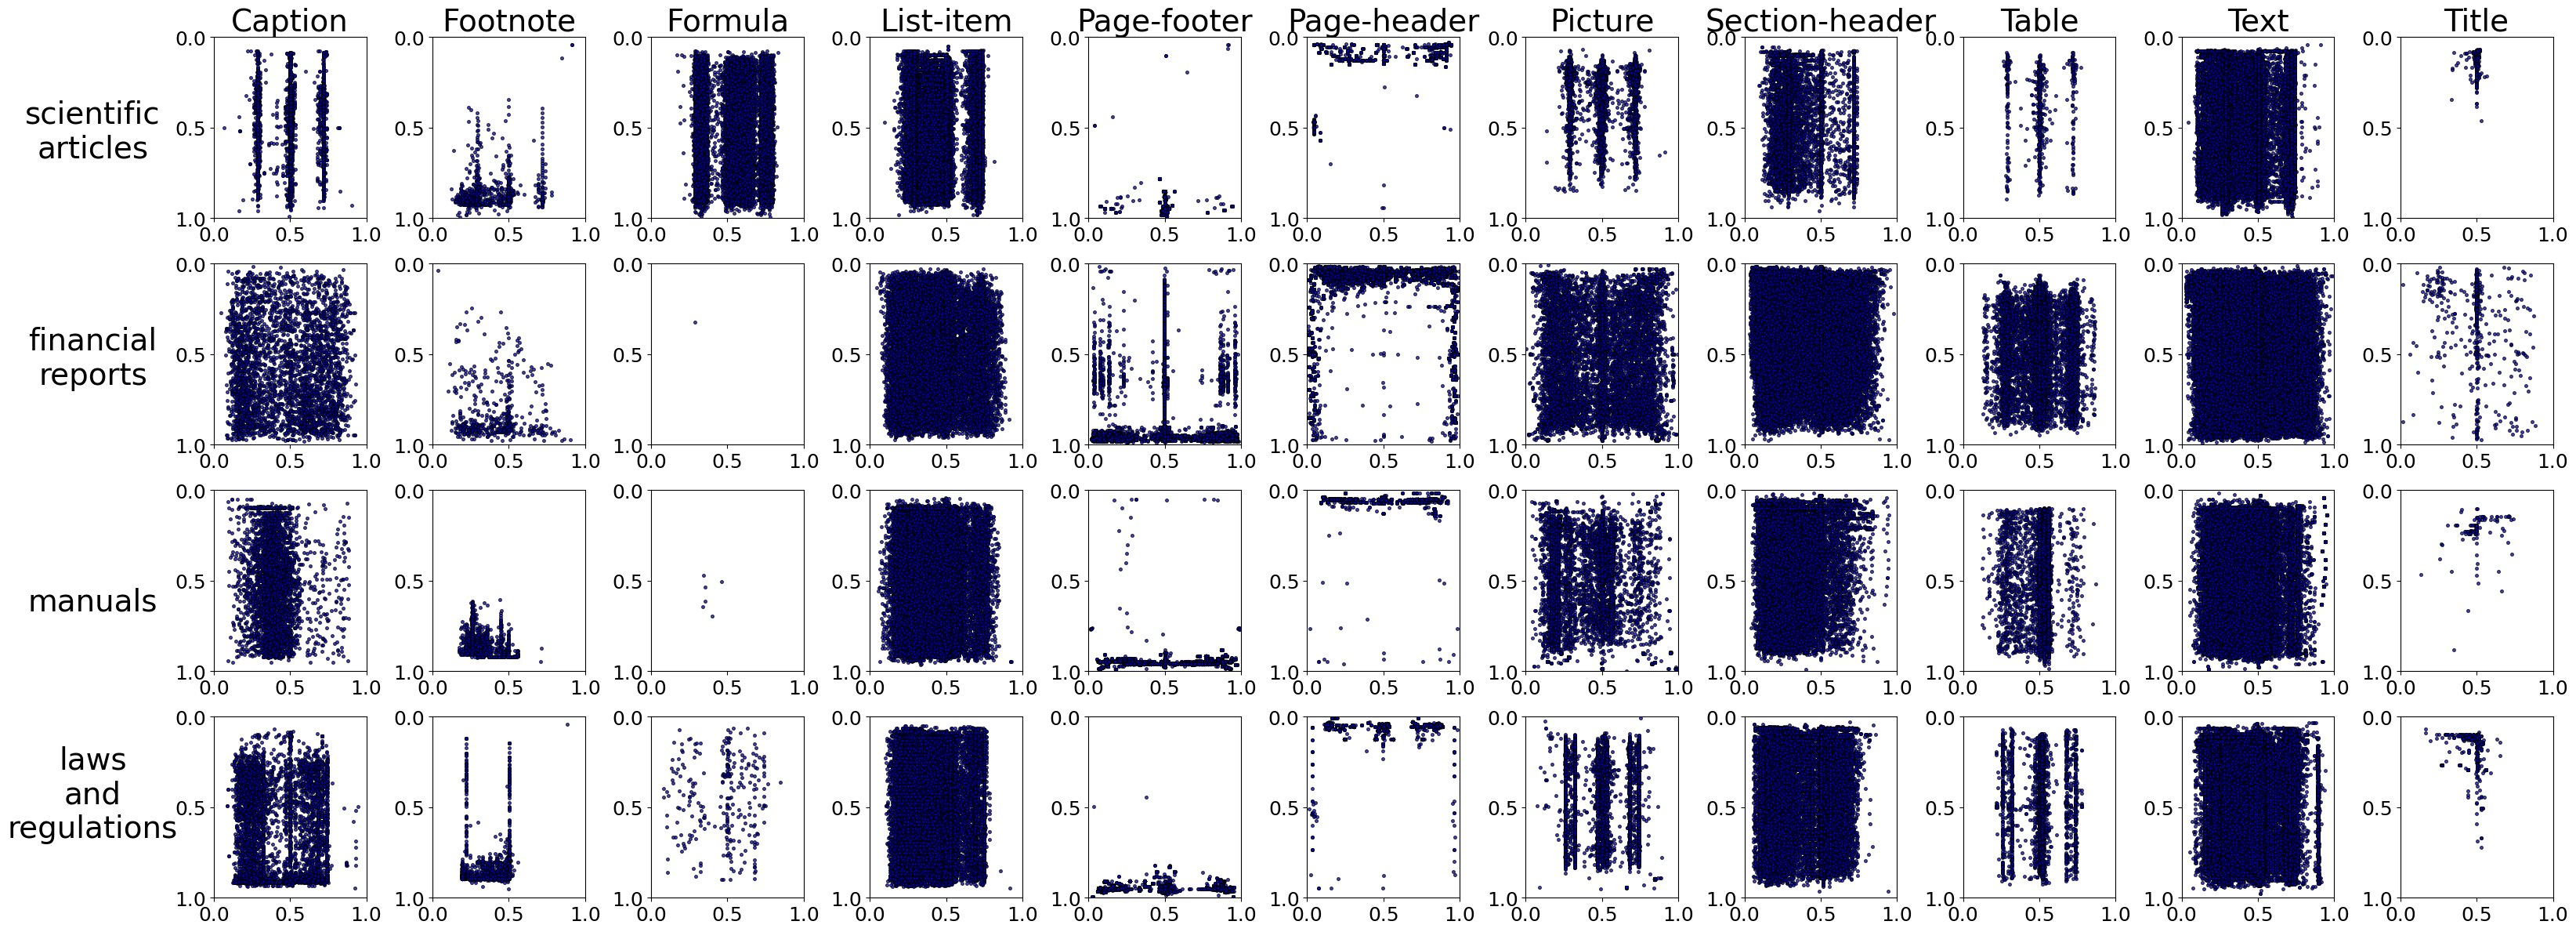

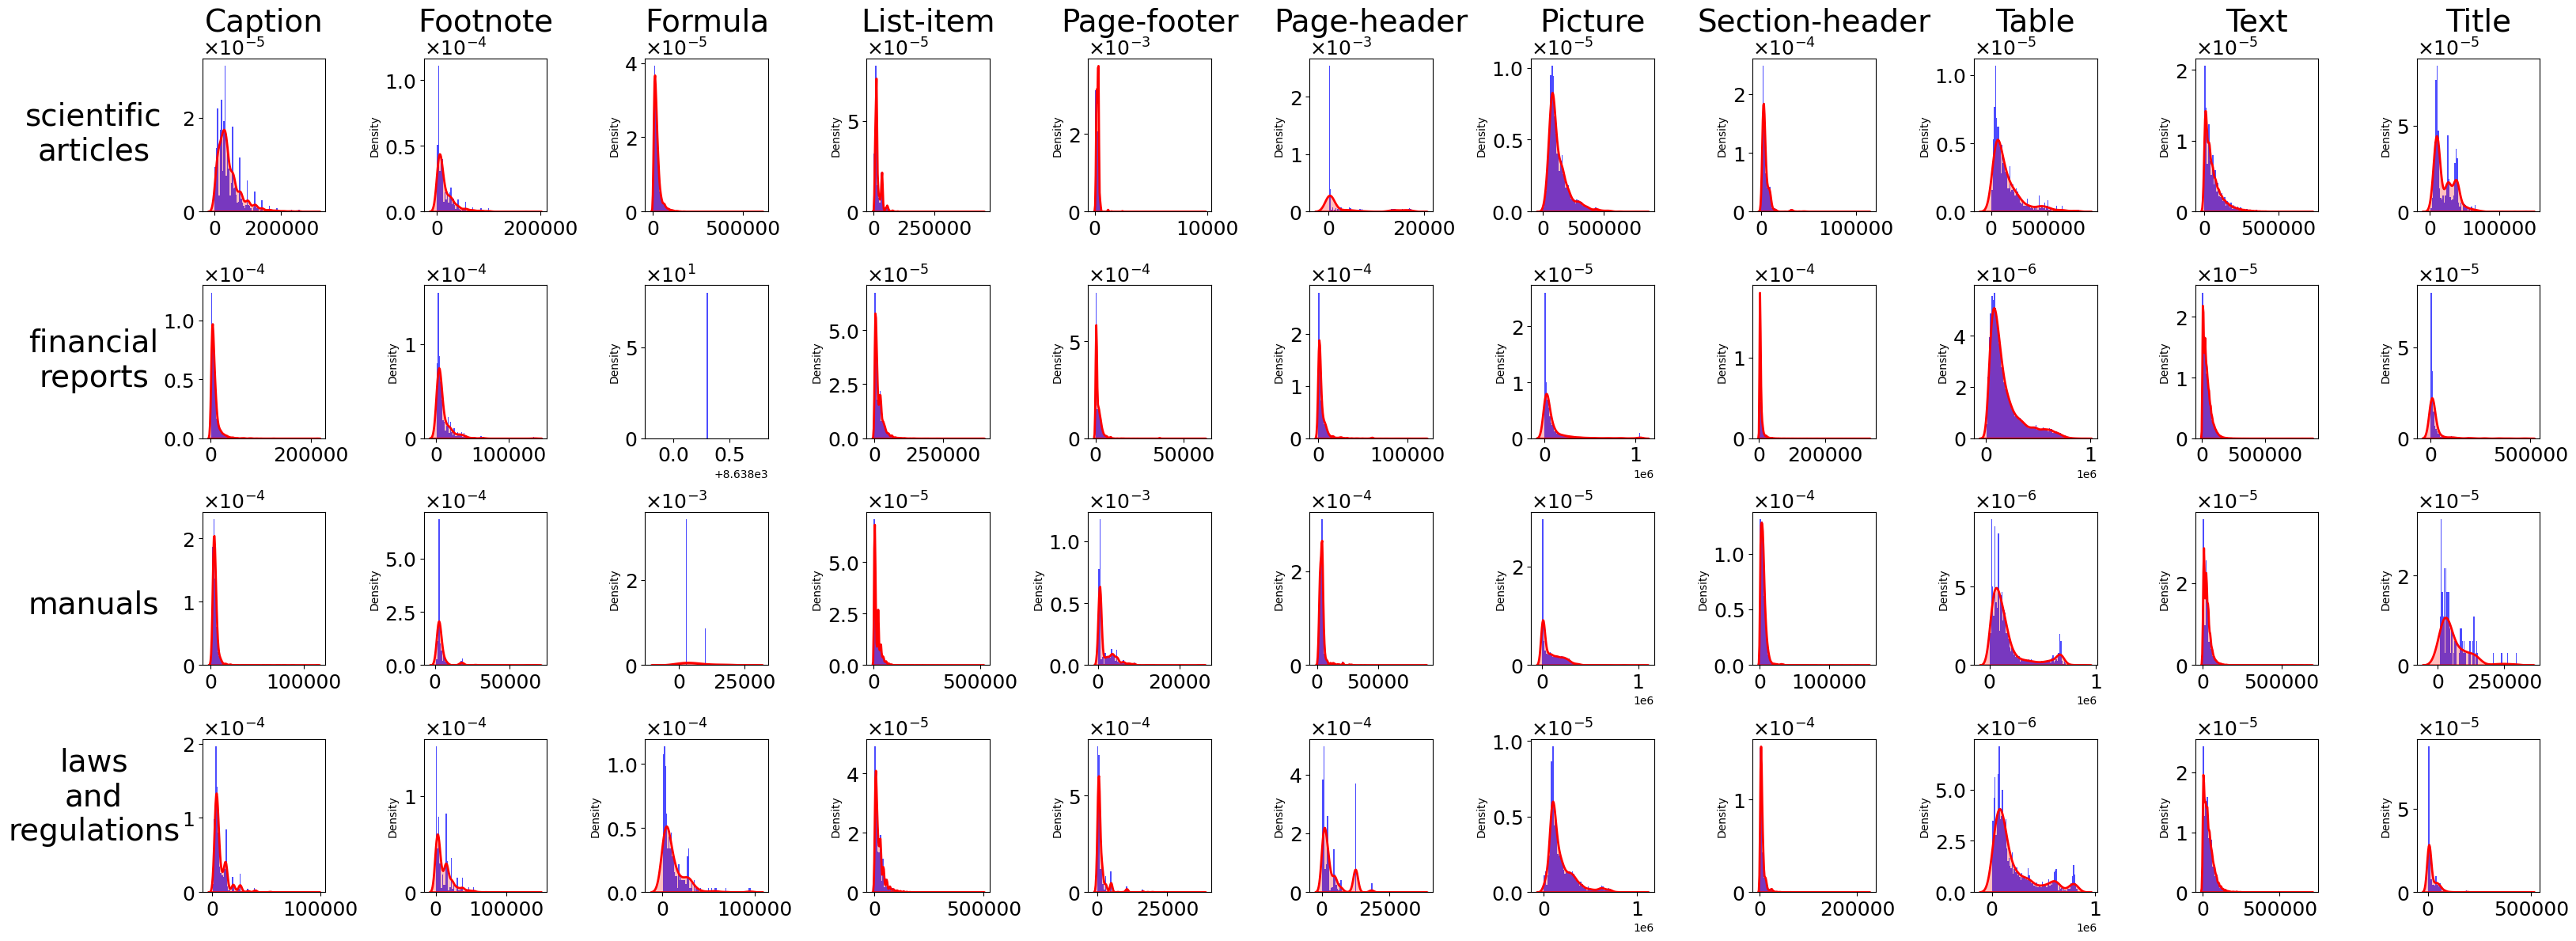

In [5]:
build_middlepoints_plot(stat_dict, number_of_classes)
build_size_distribution_plot(stat_dict, number_of_classes)